In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
import torch.optim as optim

from utils.process_img import Rescale, DynamicCrop, ToTensor, CenterCrop
from utils.func import weights_init
from pose_dataset import PoseDataset, print_sample
from model.generator import PoseGenerator
from model.discriminator import PoseDiscriminator

In [3]:
composed = transforms.Compose([Rescale(512),
                               DynamicCrop(30),
                               Rescale((128, 128))])

pose_dataset = PoseDataset('./data/data_list.csv', './data', transform = composed)
pose_dataloader = DataLoader(pose_dataset, batch_size=6, shuffle=True, num_workers=4)

In [ ]:
# for i in range(10):
#     sample = pose_dataset[i]
#     print_sample(sample)

In [ ]:
# 测试:
# embeddings = pose_dataset.embeddings

# # Generator
# netG = PoseGenerator(embeddings).cuda()
# netG.apply(weights_init)
# # Discriminator
# netD = PoseDiscriminator(embeddings).cuda()
# netD.apply(weights_init)

# for i, sample in enumerate(pose_dataloader):
#     annotate = sample['annotate'].cuda()
#     noise = torch.randn(2, 64, 1, 1).cuda()
#     fake_img = netG(noise, annotate)
#     print(fake_img.shape)
    
#     pred = netD(fake_img, annotate)
#     print(pred)
#     break

In [4]:
embeddings = pose_dataset.embeddings

# Generator
netG = PoseGenerator(embeddings).cuda()
netG.apply(weights_init)
# Discriminator
netD = PoseDiscriminator(embeddings).cuda()
netD.apply(weights_init)

# Settings:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters())
optimizerG = optim.Adam(netG.parameters())

In [5]:
# Training Loop
real_label = 1
fake_label = 0

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, sample in enumerate(pose_dataloader, 0):
        batch_size = sample['raw'].shape[0]
        # reformat the shape to be (batch_size, 3, 128, 128)
        real_pose = torch.reshape(sample['raw'], (batch_size, 3, 128, 128)).float().cuda()

        annotate = sample['annotate'].cuda()
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        label = torch.full((batch_size, ), real_label).cuda()      
        output = netD(real_pose, annotate).view(-1)        
        errD_real = criterion(output, label) # Calculate loss on all-real batch
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        noise = torch.randn(batch_size, 64, 1, 1).cuda()
        fake_pose = netG(noise, annotate)
        label.fill_(fake_label)
        output = netD(fake_pose.detach(), annotate).view(-1)                
        errD_fake = criterion(output, label)
        errD_fake.backward()

        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step() # Update D
        
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        output = netD(fake_pose, annotate).view(-1) # Since we just updated D, perform another forward pass of all-fake batch through D
        errG = criterion(output, label)
        errG.backward()
        
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(pose_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        

Starting Training Loop...
[0/5][0/57]	Loss_D: 1.4504	Loss_G: 1.2208	D(x): 0.5275	D(G(z)): 0.5367 / 0.5243
[0/5][1/57]	Loss_D: 1.8459	Loss_G: 1.1421	D(x): 0.5370	D(G(z)): 0.5182 / 0.5048
[0/5][2/57]	Loss_D: 1.7570	Loss_G: 0.6872	D(x): 0.5060	D(G(z)): 0.5352 / 0.5093
[0/5][3/57]	Loss_D: 1.4450	Loss_G: 0.6946	D(x): 0.5086	D(G(z)): 0.5092 / 0.5004
[0/5][4/57]	Loss_D: 1.4020	Loss_G: 0.7127	D(x): 0.5002	D(G(z)): 0.5002 / 0.4919
[0/5][5/57]	Loss_D: 1.4130	Loss_G: 0.7197	D(x): 0.4942	D(G(z)): 0.4933 / 0.4879
[0/5][6/57]	Loss_D: 1.3936	Loss_G: 0.7263	D(x): 0.4871	D(G(z)): 0.4870 / 0.4845
[0/5][7/57]	Loss_D: 1.3909	Loss_G: 0.7254	D(x): 0.4852	D(G(z)): 0.4852 / 0.4848
[0/5][8/57]	Loss_D: 1.3899	Loss_G: 0.7220	D(x): 0.4850	D(G(z)): 0.4850 / 0.4864
[0/5][9/57]	Loss_D: 1.3892	Loss_G: 0.7178	D(x): 0.4857	D(G(z)): 0.4858 / 0.4884
[0/5][10/57]	Loss_D: 1.3886	Loss_G: 0.7108	D(x): 0.4887	D(G(z)): 0.4887 / 0.4916
[0/5][11/57]	Loss_D: 1.3885	Loss_G: 0.7043	D(x): 0.4917	D(G(z)): 0.4917 / 0.4947
[0/5][12/57]

[1/5][45/57]	Loss_D: 1.3865	Loss_G: 0.6928	D(x): 0.5001	D(G(z)): 0.5001 / 0.5002
[1/5][46/57]	Loss_D: 1.3864	Loss_G: 0.6930	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[1/5][47/57]	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.5002	D(G(z)): 0.5002 / 0.5003
[1/5][48/57]	Loss_D: 1.3864	Loss_G: 0.6927	D(x): 0.5002	D(G(z)): 0.5002 / 0.5002
[1/5][49/57]	Loss_D: 1.3865	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[1/5][50/57]	Loss_D: 1.3864	Loss_G: 0.6928	D(x): 0.5002	D(G(z)): 0.5002 / 0.5002
[1/5][51/57]	Loss_D: 1.3865	Loss_G: 0.6938	D(x): 0.4994	D(G(z)): 0.4994 / 0.4997
[1/5][52/57]	Loss_D: 1.3864	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[1/5][53/57]	Loss_D: 1.3865	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[1/5][54/57]	Loss_D: 1.3864	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[1/5][55/57]	Loss_D: 1.3866	Loss_G: 0.6928	D(x): 0.5002	D(G(z)): 0.5002 / 0.5002
[1/5][56/57]	Loss_D: 1.3864	Loss_G: 0.6930	D(x): 0.5001	D(G(z)): 0.5001 / 0.5001
[2/5][0/57]	Loss_D: 1.3864	L

[3/5][33/57]	Loss_D: 1.3864	Loss_G: 0.6934	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[3/5][34/57]	Loss_D: 1.3863	Loss_G: 0.6933	D(x): 0.4999	D(G(z)): 0.4999 / 0.4999
[3/5][35/57]	Loss_D: 1.3863	Loss_G: 0.6935	D(x): 0.4998	D(G(z)): 0.4998 / 0.4998
[3/5][36/57]	Loss_D: 1.3863	Loss_G: 0.6936	D(x): 0.4997	D(G(z)): 0.4997 / 0.4998
[3/5][37/57]	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5000	D(G(z)): 0.5000 / 0.5001
[3/5][38/57]	Loss_D: 1.3864	Loss_G: 0.6935	D(x): 0.4997	D(G(z)): 0.4997 / 0.4998
[3/5][39/57]	Loss_D: 1.3863	Loss_G: 0.6925	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[3/5][40/57]	Loss_D: 1.3863	Loss_G: 0.6924	D(x): 0.5003	D(G(z)): 0.5003 / 0.5004
[3/5][41/57]	Loss_D: 1.3864	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[3/5][42/57]	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003
[3/5][43/57]	Loss_D: 1.3863	Loss_G: 0.6927	D(x): 0.5003	D(G(z)): 0.5003 / 0.5002
[3/5][44/57]	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5002	D(G(z)): 0.5002 / 0.5001
[3/5][45/57]	Loss_D: 1.3864	

In [ ]:
torch.cuda.empty_cache()

In [6]:
for i, sample in enumerate(pose_dataloader):
    annotate = sample['annotate'].cuda()
    noise = torch.randn(6, 64, 1, 1).cuda()
    fake_img = netG(noise, annotate)
    print(fake_img.shape)
    break

torch.Size([6, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


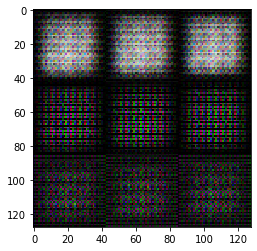

In [7]:
img = torch.reshape(fake_img[0], (128, 128, 3)).cpu().detach().numpy()
plt.imshow(img)

In [ ]:
pose_dataset[1]['raw'].shape